In [ ]:
%load_ext autoreload
%autoreload 2
from network import *

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def one_hot_encode(y):
    encoder = OneHotEncoder(sparse=False)
    y_reshaped = y.reshape(-1, 1)
    return encoder.fit_transform(y_reshaped)

iris = load_iris()
X = iris.data
y = iris.target
y = one_hot_encode(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')


## 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

In [ ]:
X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.numerical_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

In [ ]:
network.params

In [ ]:
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

## 5.7.4 오차역전파법을 사용한 학습 구현하기

### Using gradient descent

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

num_iter = 200
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

In [ ]:
info = {
    "Affain1":(X_train[0].size, 10),
    "ReLU1":(10, 10),
    "Affain2":(10, y_train[0].size),
    "SoftmaxWithLoss":(y_train[0].size, y_train[0].size)
}
network = MultiLayerNetwork(info=info)
print(network.fit(X_train, y_train, batch_size=100, epoch=1000, learning_rate=0.03))

plt.plot(np.arange(len(network.loss_log)), np.array(network.loss_log))
plt.show()

### Using moment

In [ ]:
import copy
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
alpha = 0.5
moment = copy.deepcopy(network.params)
for key in list(moment.keys()):
    moment[key] *= 0

train_loss_log = []
train_acc_log = []
test_acc_log = []
grad = None
for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
         moment[key] = alpha*moment[key] - learning_rate*grad[key]
         network.params[key] += moment[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

final loss : 0.07563152500998721 / final train accuracy : 0.9833333333333333


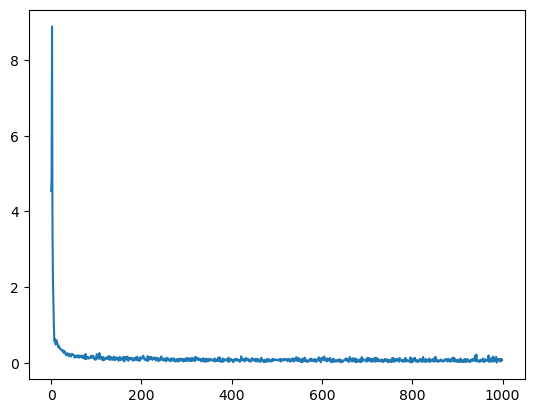

In [57]:
info = {
    "Affain1":(X_train[0].size, 10),
    "ReLU1":(10, 10),
    "Affain2":(10, y_train[0].size),
    "SoftmaxWithLoss":(y_train[0].size, y_train[0].size)
}
network = MultiLayerNetwork(info=info, optimizer="momentum")
print(network.fit(X_train, y_train, batch_size=100, epoch=1000, learning_rate=0.05, moment_const=0.7))
plt.plot(np.arange(len(network.loss_log)), np.array(network.loss_log))
plt.show()

## Visiualizing

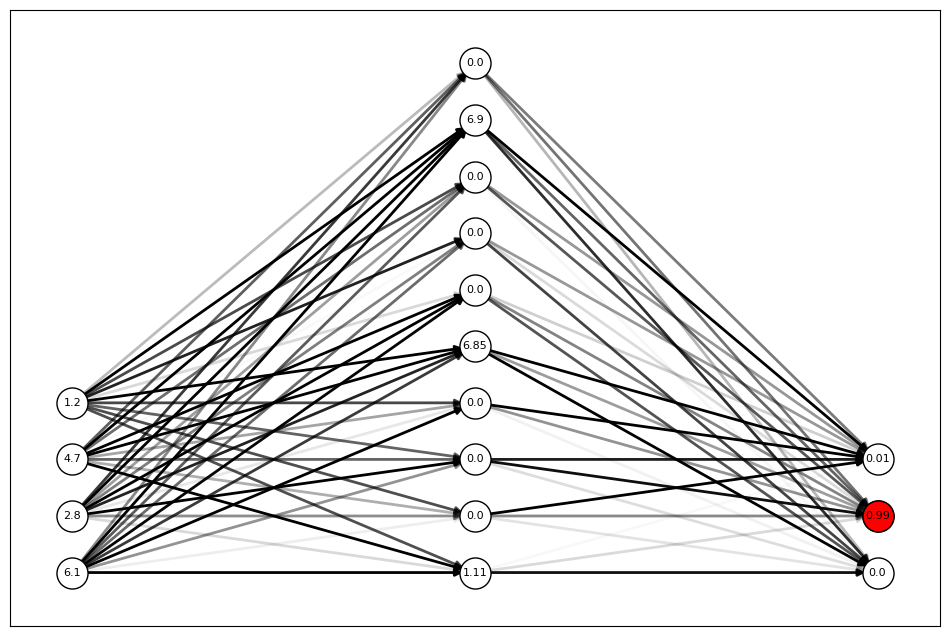

predicted class : 1
actual class : 1


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

params = network.params

def draw_neural_net(ax, G, pos, weights, activations, output):
    ax.clear()
    nx.draw_networkx_nodes(G, pos, node_color='w', node_size=500, ax=ax, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=[output], node_color='r', node_size=500, ax=ax, edgecolors='k')
    for (u, v, d) in G.edges(data=True):
        if (u, v) in weights:
            weight = weights[(u, v)]
            alpha = min(1, max(0, abs(weight)))
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=alpha, edge_color='k', ax=ax)
    labels = {i: f'{round(act, 2)}' for i, act in enumerate(activations)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])


def create_graph():
    G = nx.DiGraph()
    edges = []

    for i in range(4):
        for j in range(10):
            edges.append((i, 4 + j))

    for j in range(10):
        for k in range(3):
            edges.append((4 + j, 4 + 10 + k))

    G.add_edges_from(edges)
    return G


def get_pos():
    pos = {}
    for i in range(4):
        pos[i] = (0, i)

    for j in range(10):
        pos[4 + j] = (1, j)

    for k in range(3):
        pos[4 + 10 + k] = (2, k)

    return pos

num = 0
x_sample, y_sample = X_test[num], y_test[num] # Sample data
a1 = network.layers["ReLU1"].forward(network.layers["Affain1"].forward(x_sample))
a2 = softmax(network.layers["Affain2"].forward(a1))

weights = {(i, 4 + j): params["W1"][i, j] for i in range(4) for j in range(10)}
weights.update({(4 + j, 4 + 10 + k): params["W2"][j, k] for j in range(10) for k in range(3)})


G = create_graph()
pos = get_pos()

output_node = np.argmax(a2) + 4 + 10


fig, ax = plt.subplots(figsize=(12, 8))
activations = np.concatenate([x_sample, a1, a2])
draw_neural_net(ax, G, pos, weights, activations, output_node)
plt.show()
print(f"predicted class : {network.infer(x_sample)}\nactual class : {np.argmax(y_sample)}")